In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings


from sklearn.metrics import precision_recall_fscore_support, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB



import geopandas as gpd
from shapely.geometry import Point, Polygon



In [2]:

# At first we mount the dataset from local file
inputdf = pd.read_csv('Crime.csv')
# sneak peak in the data
inputdf.head(2)


C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\2777213038.py:2: DtypeWarning: Columns (1,18) have mixed types. Specify dtype option on import or set low_memory=False.
  inputdf = pd.read_csv('Crime.csv')


,Incident ID,Offence Code,CR Number,Dispatch Date / Time,NIBRS Code,Victims,Crime Name1,Crime Name2,Crime Name3,Police District Name,...,Street Prefix,Street Name,Street Suffix,Street Type,Start_Date_Time,End_Date_Time,Latitude,Longitude,Police District Number,Location
0,201219928,1204,180063894,12/21/2018 09:13:13 PM,120,1,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,...,NaN,GEORGIA,NaN,AVE,12/21/2018 09:13:00 PM,NaN,39.03627,-77.0499,4D,"(39.0363, -77.0499)"
1,201301798,5016,200035833,09/13/2020 12:26:58 AM,90Z,1,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,...,NaN,COLTRANE,NaN,DR,08/08/2020 05:10:00 PM,08/08/2020 12:00:00 AM,39.27784,-77.2115,5D,"(39.2778, -77.2115)"


In [3]:
print(inputdf.shape)
# 'column names are:' 
inputdf.columns
inputdf.dtypes

(312297, 30)


Incident ID                 int64
Offence Code               object
CR Number                   int64
Dispatch Date / Time       object
NIBRS Code                 object
Victims                     int64
Crime Name1                object
Crime Name2                object
Crime Name3                object
Police District Name       object
Block Address              object
City                       object
State                      object
Zip Code                  float64
Agency                     object
Place                      object
Sector                     object
Beat                       object
PRA                        object
Address Number            float64
Street Prefix              object
Street Name                object
Street Suffix              object
Street Type                object
Start_Date_Time            object
End_Date_Time              object
Latitude                  float64
Longitude                 float64
Police District Number     object
Location      

Analyzing the dataset, we observe that columns -


* Incident ID
*	Offence Code
* CR Number
* NIBRS Code
* State (All should be MD)
* Sector, Beat, PRA - meaningless
* Address Number (included in "Block Address")
* Street Prefix (lots of missing values)
* Street Suffix (lots of missing values)
* Police District Number (meaningless)
* Location (pair of Latitude and Longitude)

 are unnecessary. So they are removed.

# Later, Columns related with the effect of crime are removed.

In [4]:
unnecessary_columns = ['Dispatch Date / Time', 'Victims', 'Block Address', 'Street Type', 'Agency', 'End_Date_Time']
for i in unnecessary_columns:
  inputdf = inputdf.drop(i, axis=1)
inputdf.head(2)

,Incident ID,Offence Code,CR Number,NIBRS Code,Crime Name1,Crime Name2,Crime Name3,Police District Name,City,State,...,PRA,Address Number,Street Prefix,Street Name,Street Suffix,Start_Date_Time,Latitude,Longitude,Police District Number,Location
0,201219928,1204,180063894,120,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,SILVER SPRING,MD,...,352,11100.0,NaN,GEORGIA,NaN,12/21/2018 09:13:00 PM,39.03627,-77.0499,4D,"(39.0363, -77.0499)"
1,201301798,5016,200035833,90Z,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,DAMASCUS,MD,...,615,25600.0,NaN,COLTRANE,NaN,08/08/2020 05:10:00 PM,39.27784,-77.2115,5D,"(39.2778, -77.2115)"


Some columns are confusing to be added now. Such as -

* Crime Name3
* Zip Code
* Street Name
* Also we have to take special care of Latitude and Longitude if we want them to include in our feature set.

# Now we have to visualize the data and fix what to predict from these modified feature set

epsg:3857


<AxesSubplot:>

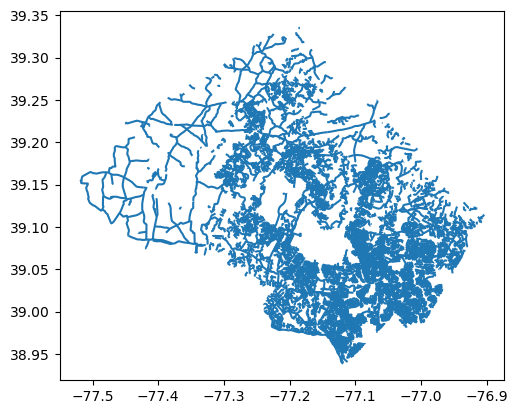

In [6]:
# Montgomery County maintained roads
# https://data.imap.maryland.gov/datasets/maryland::montgomery-county-maintained-roads/explore?location=39.168559%2C-76.905435%2C9.35
# https://catalog.data.gov/dataset/tiger-line-shapefile-2018-county-montgomery-county-md-all-roads-county-based-shapefile
# crs = {'init':'EPSG:4326'}
montgomery_county_map = gpd.read_file('MDOT_Know_Your_Roads.shp')
print(montgomery_county_map.crs) 
montgomery_county_map.to_crs(epsg=4326).plot()

# Other sources for multiple data view
# https://montgomeryplanning.org/tools/gis-and-mapping/map-library/

# Drop rows from the dataframe based on certain condition applied on a column


In [7]:
# Filter all rows for Latitude is greater than or equal to 35
inputdf = inputdf[inputdf['Latitude'] > 35.0]
# inputdf['Latitude'].hist()

In [8]:
# Filter all rows for Longitude is less than or equal to -70
inputdf = inputdf[inputdf['Longitude'] < -70]
# inputdf['Longitude'].hist()

In [9]:
# inputdf['Crime Name2'].value_counts()
# # Filter all rows for that has occurances less than 5
# inputdf = inputdf[inputdf.columns[inputdf['Crime Name2'].value_counts() > 5]]

In [10]:
inputdf['Crime Name2'].value_counts()

All Other Offenses                             72203
Theft From Motor Vehicle                       26252
Drug/Narcotic Violations                       22573
Simple Assault                                 21064
Destruction/Damage/Vandalism of Property       18967
Shoplifting                                    16416
All other Larceny                              13972
Driving Under the Influence                    13723
Theft from Building                            11335
Burglary/Breaking and Entering                  8784
Identity Theft                                  8633
Theft of Motor Vehicle Parts or Accessories     6747
Liquor Law Violations                           6565
Motor Vehicle Theft                             6489
False Pretenses/Swindle/Confidence Game         6438
Disorderly Conduct                              4980
Credit Card/Automatic Teller Machine Fraud      4726
Aggravated Assault                              4313
Trespass of Real Property                     

# Export Pandas DataFrame to CSV


In [11]:

# inputdf.to_csv('potential feature set revised.csv')


# ‘geo_df’ that is a copy of our original data frame but with the newly created ‘geometry’ column.


In [12]:
crs = {'init':'EPSG:4326'}
geometry = [Point(xy) for xy in zip(inputdf['Longitude'], inputdf['Latitude'])]
geo_df = gpd.GeoDataFrame(inputdf, 
                          crs = crs, 
                          geometry = geometry)

geo_df.head()

c:\ProgramData\Anaconda3\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,Incident ID,Offence Code,CR Number,NIBRS Code,Crime Name1,Crime Name2,Crime Name3,Police District Name,City,State,...,Address Number,Street Prefix,Street Name,Street Suffix,Start_Date_Time,Latitude,Longitude,Police District Number,Location,geometry
0,201219928,1204,180063894,120,Crime Against Property,Robbery,ROBBERY - STREET-GUN,WHEATON,SILVER SPRING,MD,...,11100.0,NaN,GEORGIA,NaN,12/21/2018 09:13:00 PM,39.036270,-77.049900,4D,"(39.0363, -77.0499)",POINT (-77.04990 39.03627)
1,201301798,5016,200035833,90Z,Crime Against Society,All Other Offenses,OBSTRUCT GOVT - VIOLATION OF A COURT ORDER,GERMANTOWN,DAMASCUS,MD,...,25600.0,NaN,COLTRANE,NaN,08/08/2020 05:10:00 PM,39.277840,-77.211500,5D,"(39.2778, -77.2115)",POINT (-77.21150 39.27784)
2,201221577,5404,190000342,90D,Crime Against Society,Driving Under the Influence,DRIVING UNDER THE INFLUENCE LIQUOR,ROCKVILLE,ROCKVILLE,MD,...,NaN,N,GRANDIN,NaN,01/03/2019 02:48:00 AM,39.086688,-77.144754,1D,"(39.0867, -77.1448)",POINT (-77.14475 39.08669)
3,201221577,9053,190000342,90Z,Other,All Other Offenses,LITTERING/TRASH DUMPING,ROCKVILLE,ROCKVILLE,MD,...,NaN,N,GRANDIN,NaN,01/03/2019 02:48:00 AM,39.086688,-77.144754,1D,"(39.0867, -77.1448)",POINT (-77.14475 39.08669)
4,201294935,2303,200027681,23C,Crime Against Property,Shoplifting,LARCENY - SHOPLIFTING,GERMANTOWN,GERMANTOWN,MD,...,20900.0,NaN,FREDERICK,NaN,07/16/2020 05:29:00 PM,39.198295,-77.244900,5D,"(39.1983, -77.2449)",POINT (-77.24490 39.19830)


<AxesSubplot:>

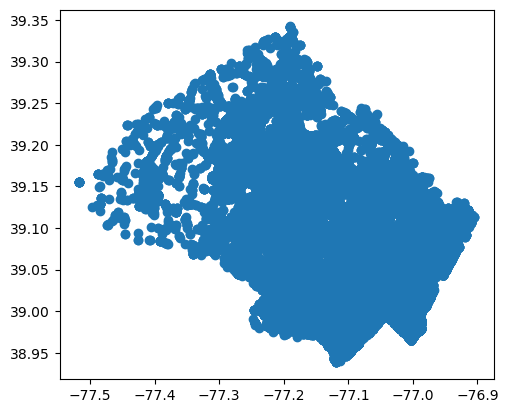

In [13]:
geo_df.plot()

# Visualizing the Crime Data

Text(0.5, 1.0, 'Montgomery County Crime type data Heatmap')

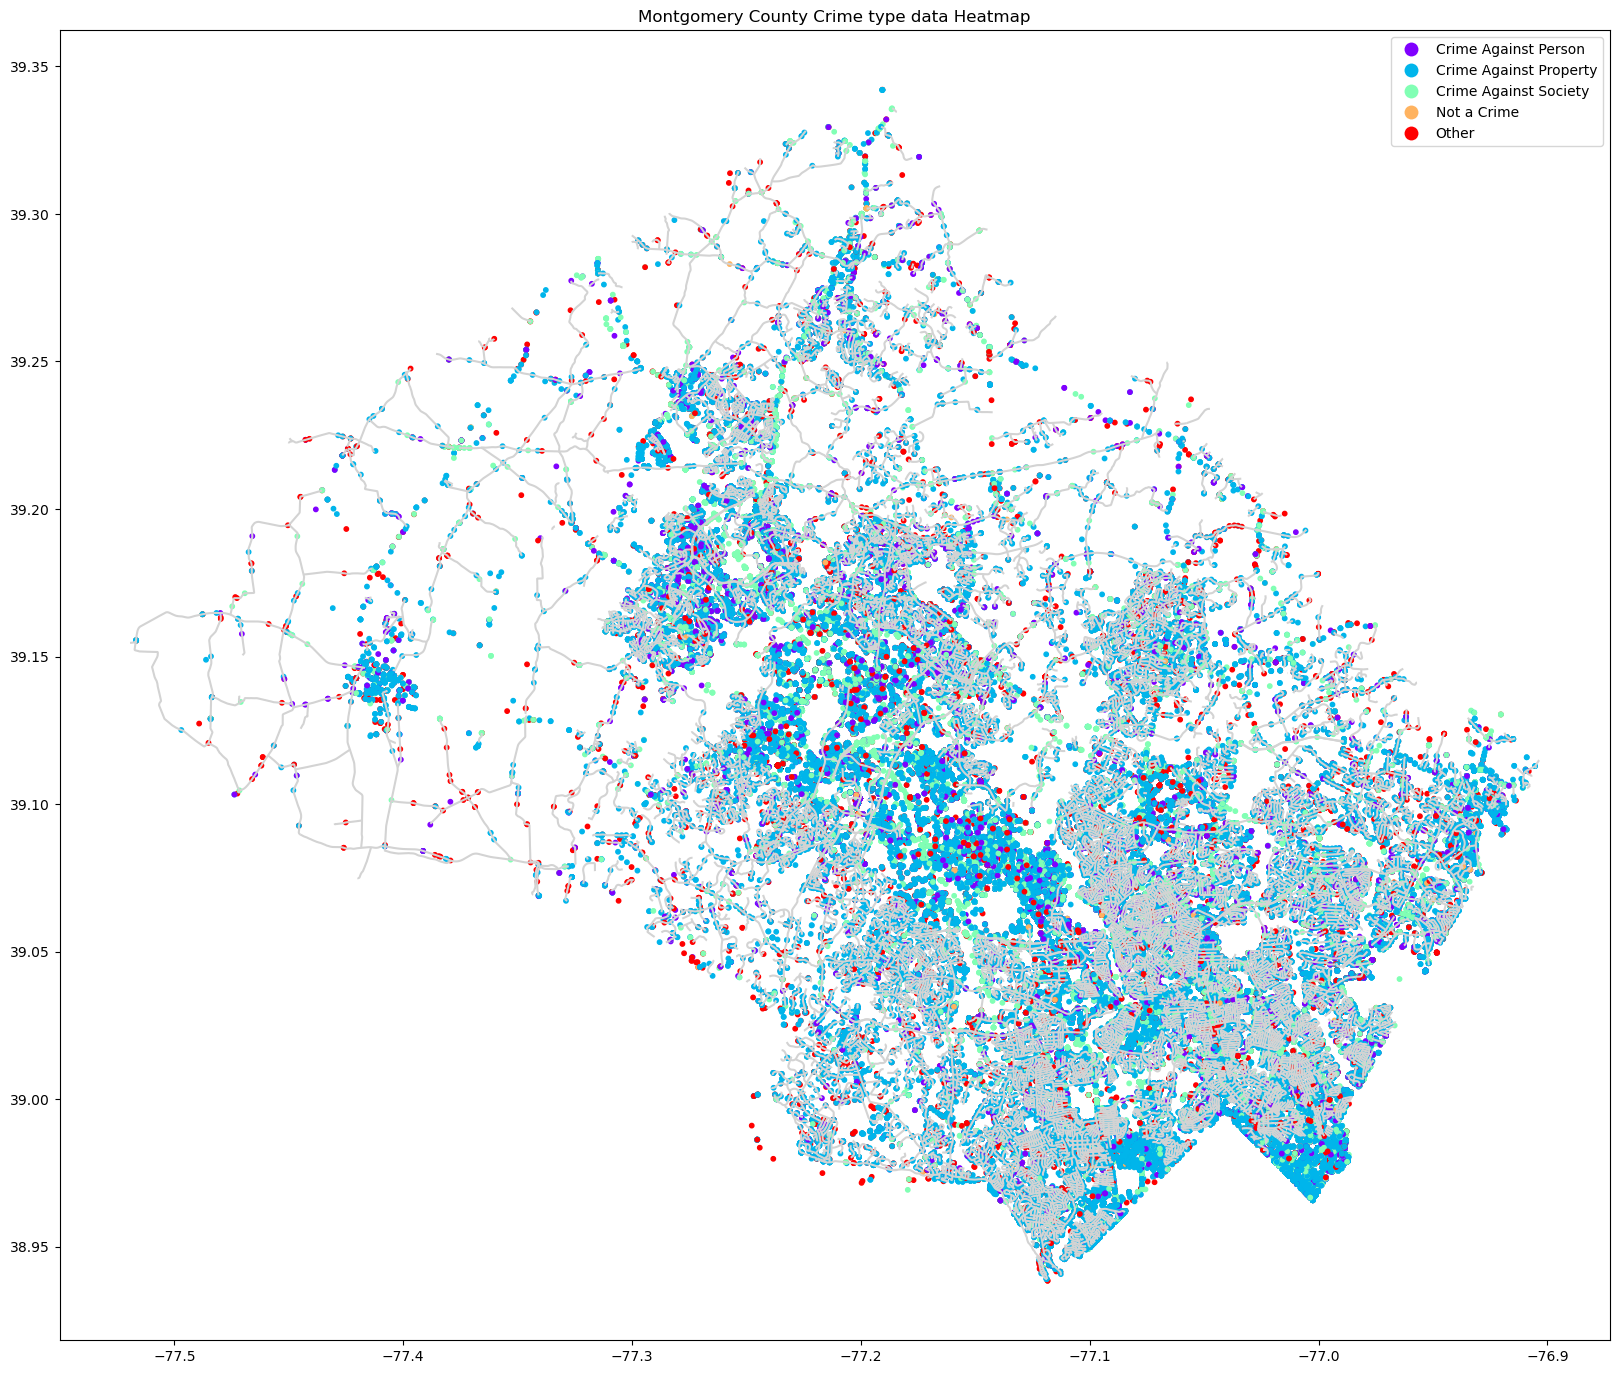

In [14]:
fig, ax = plt.subplots(figsize = (20,20))
montgomery_county_map.to_crs(epsg=4326).plot(ax=ax, color='lightgrey')
geo_df.plot(column = geo_df['Crime Name1'], ax=ax, cmap = 'rainbow',
            legend = True, #legend_kwds={'shrink': 0.3}, 
            markersize = 10)
ax.set_title('Montgomery County Crime type data Heatmap')
# plt.savefig('Crime Heat Map for Location')

In [15]:
#geo_df['Crime Name1'].hist()
geo_df['Crime Name2'].count()
geo_df['Crime Name2'].value_counts()
# geo_df.groupby('Crime Name2').count() # per group data count


#geo_df['Latitude'].hist()

All Other Offenses                             72203
Theft From Motor Vehicle                       26252
Drug/Narcotic Violations                       22573
Simple Assault                                 21064
Destruction/Damage/Vandalism of Property       18967
Shoplifting                                    16416
All other Larceny                              13972
Driving Under the Influence                    13723
Theft from Building                            11335
Burglary/Breaking and Entering                  8784
Identity Theft                                  8633
Theft of Motor Vehicle Parts or Accessories     6747
Liquor Law Violations                           6565
Motor Vehicle Theft                             6489
False Pretenses/Swindle/Confidence Game         6438
Disorderly Conduct                              4980
Credit Card/Automatic Teller Machine Fraud      4726
Aggravated Assault                              4313
Trespass of Real Property                     

# Separating Train and Test Set for Crime Prediction for Location

In [16]:
print(inputdf['Crime Name1'].value_counts())

Crime Against Property    140262
Crime Against Society      66848
Other                      62981
Crime Against Person       30221
Not a Crime                 3590
Name: Crime Name1, dtype: int64


# Creating The Location Based Crime Data Frame

In [17]:
# loc_crime_df = inputdf[['Latitude', 'Longitude', 'Crime Name1']]
loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Zip Code', 'Place', 'Street Name', 'Latitude', 'Longitude']]
dates = pd.to_datetime(inputdf['Start_Date_Time'])
  
# extract Hours from Timestamp 
# rs = dates.dt.hour
# print(rs)
loc_crime_df['dateHour'] = dates.dt.hour
loc_crime_df['day'] = dates.dt.day
loc_crime_df['month'] = dates.dt.month
loc_crime_df.head()
# print(loc_crime_df.shape)
# loc_crime_df.dtypes


C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\1410415303.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_crime_df['dateHour'] = dates.dt.hour
C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\1410415303.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_crime_df['day'] = dates.dt.day
C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\1410415303.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
0,Crime Against Property,Robbery,WHEATON,SILVER SPRING,20902.0,Street - Bus Stop,GEORGIA,39.036270,-77.049900,21,21,12
1,Crime Against Society,All Other Offenses,GERMANTOWN,DAMASCUS,20872.0,Parking Lot - Residential,COLTRANE,39.277840,-77.211500,17,8,8
2,Crime Against Society,Driving Under the Influence,ROCKVILLE,ROCKVILLE,20850.0,Street - In vehicle,GRANDIN,39.086688,-77.144754,2,3,1
3,Other,All Other Offenses,ROCKVILLE,ROCKVILLE,20850.0,Street - Other,GRANDIN,39.086688,-77.144754,2,3,1
4,Crime Against Property,Shoplifting,GERMANTOWN,GERMANTOWN,20876.0,Retail - Department/Discount Store,FREDERICK,39.198295,-77.244900,17,16,7


In [18]:
 # Removing Rows on Count condition
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)
threshold = 100
loc_crime_df = loc_crime_df.loc[loc_crime_df['Crime Name2'].isin(counts.index[counts >= threshold ])]



In [19]:
 # Removing Rows on Count condition 
 # Pruning garbage data
# loc_crime_df = loc_crime_df[~loc_crime_df['Crime Name2'] == "All Other Offenses"]
indexAge = loc_crime_df[ loc_crime_df['Crime Name2'] == "All Other Offenses" ].index
loc_crime_df.drop(indexAge , inplace=True)
loc_crime_df.head()
counts = loc_crime_df['Crime Name2'].value_counts()
# print(counts)


# Taking only Top n classes in a column


In [20]:
target_column = 'Crime Name2'
top_n = 10
top_classes = {}
top_classes = loc_crime_df[target_column].value_counts().nlargest(top_n).to_dict()
print(top_classes)
str_array = []
temp_df = pd.DataFrame()
for x in top_classes.keys():
    str_array.append(x)
    rows = loc_crime_df[loc_crime_df[target_column] == str (x) ]
    # print(rows)
    temp_df = temp_df.append(rows)
# print(str_array)
# temp_df

{'Theft From Motor Vehicle': 26252, 'Drug/Narcotic Violations': 22573, 'Simple Assault': 21064, 'Destruction/Damage/Vandalism of Property': 18967, 'Shoplifting': 16416, 'All other Larceny': 13972, 'Driving Under the Influence': 13723, 'Theft from Building': 11335, 'Burglary/Breaking and Entering': 8784, 'Identity Theft': 8633}


C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\1703158715.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(rows)
C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\1703158715.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(rows)
C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\1703158715.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(rows)
C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\1703158715.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  temp_df = temp_df.append(rows)
C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\1703158715.py:

In [21]:
# print(temp_df[target_column].value_counts())
loc_crime_df = temp_df
print(loc_crime_df[target_column].value_counts())

Theft From Motor Vehicle                    26252
Drug/Narcotic Violations                    22573
Simple Assault                              21064
Destruction/Damage/Vandalism of Property    18967
Shoplifting                                 16416
All other Larceny                           13972
Driving Under the Influence                 13723
Theft from Building                         11335
Burglary/Breaking and Entering               8784
Identity Theft                               8633
Name: Crime Name2, dtype: int64


# Dropping null values in Zip code

In [22]:
loc_crime_df['Zip Code'].value_counts()
# loc_crime_df['dateHour'].value_counts()

20910.0    13748
20902.0    11942
20874.0     9931
20904.0     9842
20906.0     9705
           ...  
20806.0        1
20287.0        1
28051.0        1
29004.0        1
21797.0        1
Name: Zip Code, Length: 121, dtype: int64

In [23]:
loc_crime_df = loc_crime_df.dropna(axis=0, subset=['Zip Code'])
print(loc_crime_df.shape)

(159991, 12)


In [24]:
# loc_crime_df['Crime Name2'].count()
# loc_crime_df['Crime Name2'].value_counts()

# Transform the data by label encoding

In [25]:
encoded_dict ={}
temp_df_2 = pd.DataFrame()

def label_encoder(y):
    le = LabelEncoder()
    if str(y) == target_column:
        print(loc_crime_df[y])
    loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
    if str(y) == target_column:
        print(loc_crime_df[y])
    if str(y) == target_column:
        temp_df_2[y] = le.inverse_transform(loc_crime_df[y])
        # encoded_dict = {loc_crime_df[y], temp_df_2[y]} 
    #print(temp_df[y])

#loc_crime_df = inputdf[['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']]

label_list = ['Crime Name1','Crime Name2', 'Police District Name', 'City', 'Place', 'Street Name']
#label_list = ['Crime Name1']

for l in label_list:
    label_encoder(l)

# print(encoded_dict)
 
#Display transformed data
loc_crime_df.head()

20        Theft From Motor Vehicle
31        Theft From Motor Vehicle
61        Theft From Motor Vehicle
98        Theft From Motor Vehicle
116       Theft From Motor Vehicle
                    ...           
312116              Identity Theft
312129              Identity Theft
312201              Identity Theft
312240              Identity Theft
312248              Identity Theft
Name: Crime Name2, Length: 159991, dtype: object
20        8
31        8
61        8
98        8
116       8
         ..
312116    5
312129    5
312201    5
312240    5
312248    5
Name: Crime Name2, Length: 159991, dtype: int32


C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\994831327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\994831327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loc_crime_df[y] = le.fit_transform(loc_crime_df[y])
C:\Users\shawo\AppData\Local\Temp\ipykernel_17480\994831327.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

,Crime Name1,Crime Name2,Police District Name,City,Zip Code,Place,Street Name,Latitude,Longitude,dateHour,day,month
20,1,8,6,34,20904.0,45,835,39.08299,-76.9481,11,7,11
31,1,8,5,32,20852.0,45,3382,39.05840,-77.1263,20,27,1
61,1,8,6,34,20904.0,45,5122,39.06081,-76.9634,10,17,9
98,1,8,0,11,20815.0,61,2638,39.00547,-77.0720,20,28,12
116,1,8,2,19,20874.0,51,6189,39.15549,-77.2763,18,26,12


In [26]:
# print(loc_crime_df['Crime Name1'].value_counts())
# print(temp_df['Crime Name1'].value_counts())

# Divide the dataset into independent and dependent variables


In [27]:
# Going for specigic prediction without geolocation
X = loc_crime_df.drop([target_column],axis=1)
y = loc_crime_df[target_column]

# Going for specigic prediction without geolocation
# X = loc_crime_df.drop([target_column, 'Latitude', 'Longitude'],axis=1)
# y = loc_crime_df[target_column]


# Going for generic prediction
# X = loc_crime_df.drop([target_column,'Crime Name2', 'Latitude', 'Longitude'],axis=1)
# y = loc_crime_df[target_column]

print(X)


        Crime Name1  Police District Name  City  Zip Code  Place  Street Name  \
20                1                     6    34   20904.0     45          835   
31                1                     5    32   20852.0     45         3382   
61                1                     6    34   20904.0     45         5122   
98                1                     0    11   20815.0     61         2638   
116               1                     2    19   20874.0     51         6189   
...             ...                   ...   ...       ...    ...          ...   
312116            1                     5    32   20852.0     37         5264   
312129            1                     2     6   20841.0     37         3539   
312201            1                     2    19   20874.0     37           79   
312240            1                     5    17   20878.0     37         5831   
312248            1                     2    12   20871.0     15         1489   

        Latitude  Longitude

In [28]:
print(y.value_counts())

8    25821
4    22237
7    20985
2    18776
6    16345
0    13819
3    13509
9    11156
1     8712
5     8631
Name: Crime Name2, dtype: int64


In [29]:
#Split the data into training and testing set
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,
                                               random_state=42, shuffle = True) 

#Data was splitted as 80% train data and 20% test data.

# y_train = y_train.values.reshape(-1,1)
# y_test = y_test.values.reshape(-1,1)

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

X_train shape: (127992, 11)
X_test shape: (31999, 11)
y_train shape: (127992,)
y_test shape: (31999,)


In [30]:
#Feature Scaling (Standardize the data)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# We will build all six models and compare their accuracy scores.



In [31]:
#To store results of models, we create two dictionaries
result_dict_train = {}
result_dict_test = {}

# Machine Leaning Models and their performance


In [32]:
models = {'Naïve Bayes Classifier': GaussianNB, 'Decision Tree Classifier' : DecisionTreeClassifier, 'KNN Classifier': KNeighborsClassifier,
        'Random Forest Classifier': RandomForestClassifier,'Logistic Regression': LogisticRegression}
        # , 'Support Vector Classifier': SVC}
# for keys, values in sorted(models.items()):
#     print(keys +" is "+ values)

warnings.filterwarnings("ignore")

# for name, model in models.items():
#     print(name +" is "+ model)
    

Naïve Bayes Classifier is running
Train Score: 0.446902896192355
Test Score: 0.4515766117691178
Test Score (F1 - micro): 0.4515766117691178
Test Score (F1 - macro): 0.35298434070892604
Test Score (F1 - weighted): 0.40532456692903684
Normalized confusion matrix


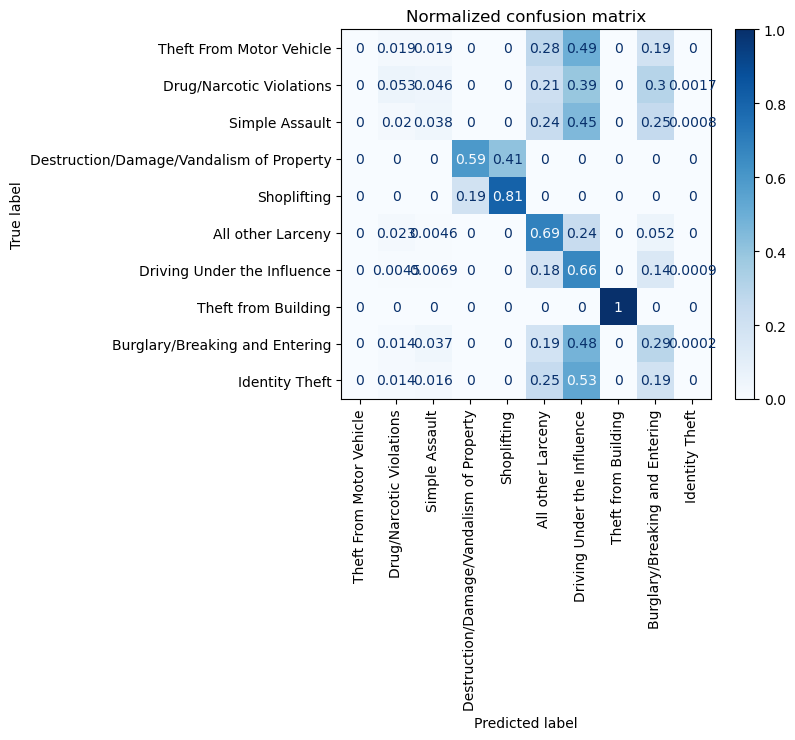

Decision Tree Classifier is running
Train Score: 0.5909432154190946
Test Score: 0.5892371636613645
Test Score (F1 - micro): 0.5892371636613645
Test Score (F1 - macro): 0.5521470603550254
Test Score (F1 - weighted): 0.590758579194316
Normalized confusion matrix


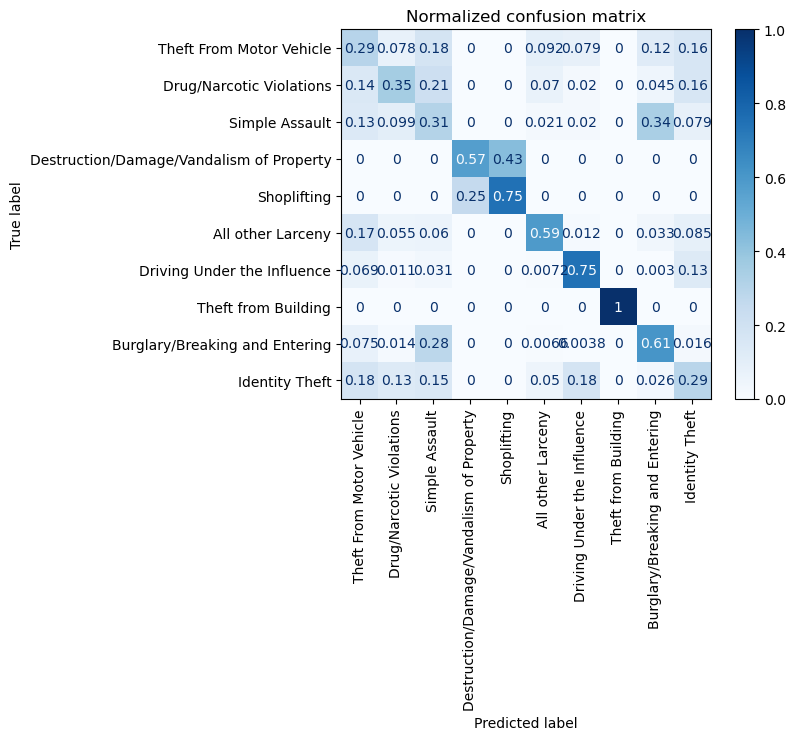

KNN Classifier is running
Train Score: 0.5456669640068081
Test Score: 0.5538923091346605
Test Score (F1 - micro): 0.5538923091346605
Test Score (F1 - macro): 0.4943891646371559
Test Score (F1 - weighted): 0.5452841193202942
Normalized confusion matrix


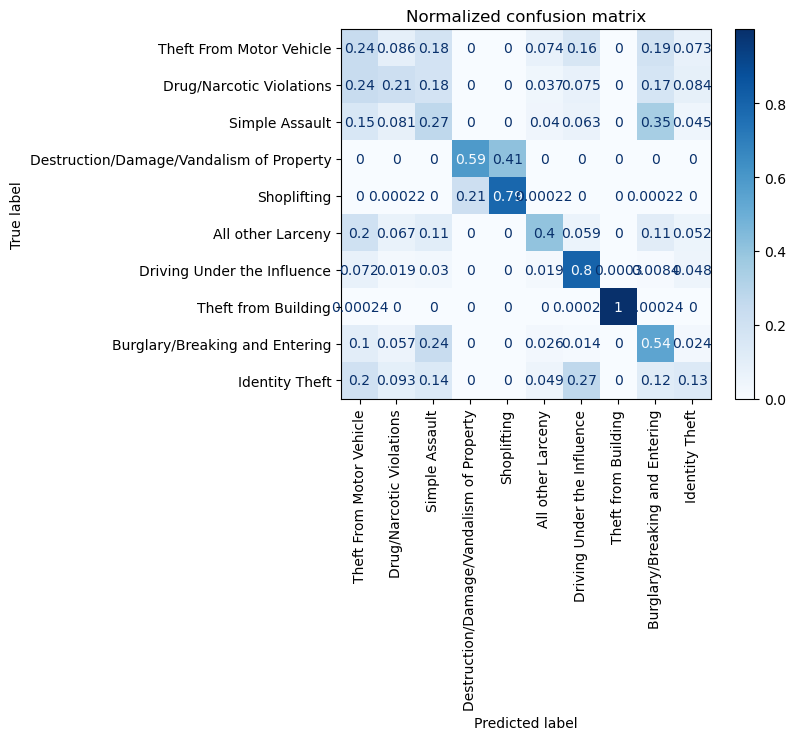

Random Forest Classifier is running
Train Score: 0.6577910950325261
Test Score: 0.6547079596237383
Test Score (F1 - micro): 0.6547079596237383
Test Score (F1 - macro): 0.6072339246747973
Test Score (F1 - weighted): 0.641395129972696
Normalized confusion matrix


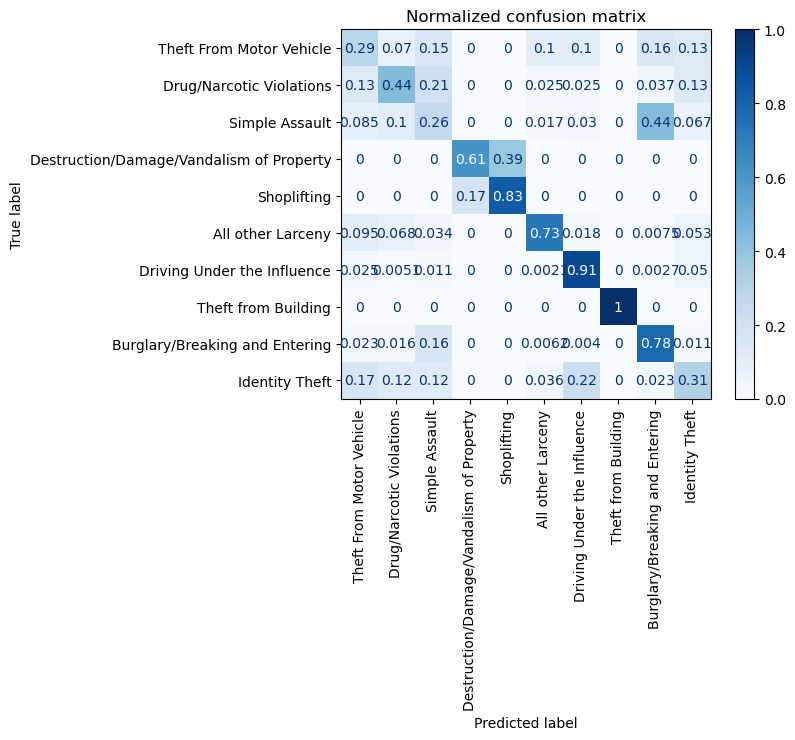

Logistic Regression is running
Train Score: 0.4646853089940798
Test Score: 0.4585143285727679
Test Score (F1 - micro): 0.4585143285727679
Test Score (F1 - macro): 0.3321301979538487
Test Score (F1 - weighted): 0.3944987723724648
Normalized confusion matrix


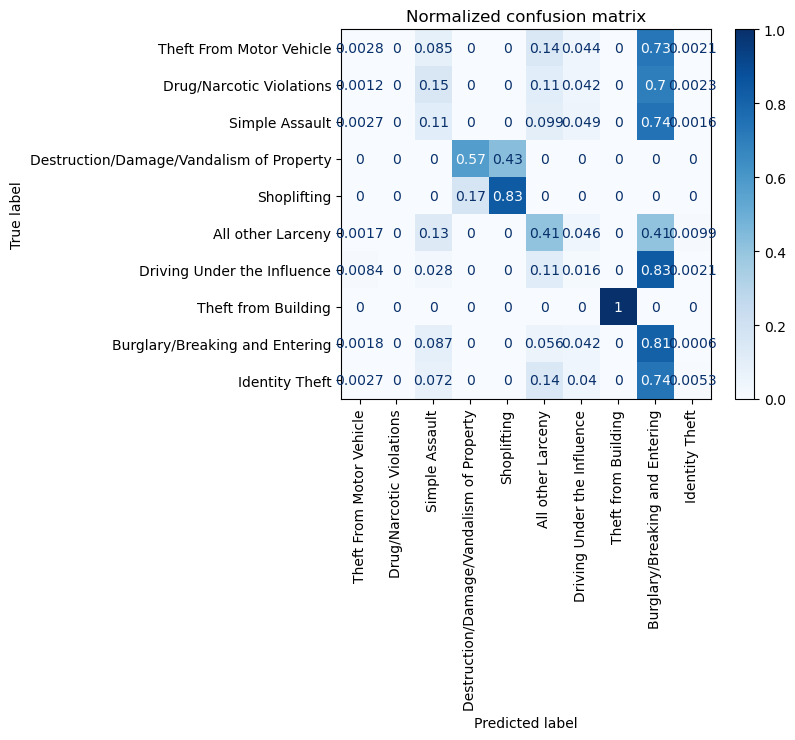

In [33]:
for model_name, model_function in models.items():
    print(model_name +' is running')
    try:
        model = model_function(random_state = 42)
    except:
        if(model_name=='Logistic Regression'):
            model = model_function(solver='lbfgs', max_iter=1000)
        model = model_function()
    accuracies = cross_val_score(model, X_train, y_train, cv=5)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    #Obtain accuracy
    print("Train Score:",np.mean(accuracies))
    print("Test Score:",model.score(X_test,y_test))
    # print("Test Score (F1 - micro):",f1_score(y_test, y_pred, average='micro'))
    # print("Test Score (F1 - macro):",f1_score(y_test, y_pred, average='macro'))
    # print("Test Score (F1 - weighted):",f1_score(y_test, y_pred, average='weighted'))

    #Confusion matrix
    # plot_confusion_matrix(model, X_test, y_test)  
    # plt.show()

    
    # Plot non-normalized confusion matrix
    titles_options = [
        ("Normalized confusion matrix", "true"),
    ]
    for title, normalize in titles_options:
        disp = ConfusionMatrixDisplay.from_estimator(
            model,
            X_test,
            y_test,
            display_labels=str_array,
            cmap=plt.cm.Blues,
            normalize=normalize,
            xticks_rotation=90,
            #yticks_rotation=75,
        )
        disp.ax_.set_title(title)
        # ax[0].set_xticklabels(df_result_train.index,rotation = 75)
        # ax[1].set_xticklabels(df_result_test.index,rotation = 75)

        print(title)
        #print(disp.confusion_matrix)

    plt.show()


    #Store results in the dictionaries
    result_dict_train['Train Score for '+model_name] = np.mean(accuracies)
    result_dict_test['Test Score for '+model_name] = model.score(X_test,y_test)
    


# Compare Accuracy Scores

In [34]:
df_result_train = pd.DataFrame.from_dict(result_dict_train,orient = "index", columns=["Score"])
print(df_result_train)

df_result_test = pd.DataFrame.from_dict(result_dict_test,orient = "index",columns=["Score"])
df_result_test


                                             Score
Train Score for Naïve Bayes Classifier    0.446903
Train Score for Decision Tree Classifier  0.590943
Train Score for KNN Classifier            0.545667
Train Score for Random Forest Classifier  0.657791
Train Score for Logistic Regression       0.464685


,Score
Test Score for Naïve Bayes Classifier,0.451577
Test Score for Decision Tree Classifier,0.589237
Test Score for KNN Classifier,0.553892
Test Score for Random Forest Classifier,0.654708
Test Score for Logistic Regression,0.458514


# Display the accuracy scores

[Text(0, 0, 'Test Score for Naïve Bayes Classifier'),
 Text(1, 0, 'Test Score for Decision Tree Classifier'),
 Text(2, 0, 'Test Score for KNN Classifier'),
 Text(3, 0, 'Test Score for Random Forest Classifier'),
 Text(4, 0, 'Test Score for Logistic Regression')]

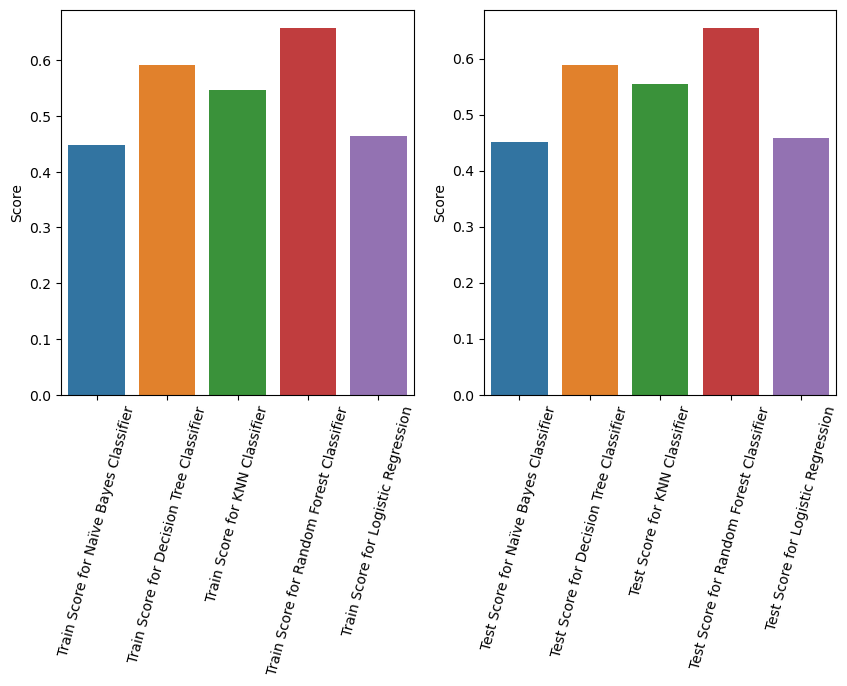

In [35]:
import seaborn as sns

fig,ax = plt.subplots(1,2,figsize=(10,5))
sns.barplot(x = df_result_train.index,y = df_result_train.Score,ax = ax[0])
sns.barplot(x = df_result_test.index,y = df_result_test.Score,ax = ax[1])
ax[0].set_xticklabels(df_result_train.index,rotation = 75)
ax[1].set_xticklabels(df_result_test.index,rotation = 75)
#plt.show()
# plt.savefig('Predicting Specific Crime With Location')